In [1]:
import numpy as np

import os
import pickle
from joblib import Parallel, delayed

from dynamics_plotting_utils import timescale_analysis

NNETWORKS = 100
NNODES = 400

experiment_path = 'results/empirical/empirical_MC_gamma1/'
module_mappings = pickle.load(open(os.path.join(experiment_path, 'network_data/module_mappings.pickle'), 'rb'))
nmodules = len(np.unique(module_mappings))

In [2]:
#empirical timescales
rs_path = os.path.join(experiment_path, 'reservoir_states')

timescales = np.zeros((NNETWORKS*nmodules, NNODES))
i = 0
for rs_file in os.listdir(rs_path):
    if 'stable' in rs_file and 'empirical' in rs_file:

        filename = rs_file.split('/')[-1]
        #Get the input module
        module = filename.split('_')[-2]
        module = int(module[6:])
        input_nodes = np.where(module_mappings == module)[0]
        output_nodes = np.where(module_mappings != module)[0]

        rs = np.load(os.path.join(rs_path, rs_file), allow_pickle=True)
        rs = rs.T
        rs = rs[output_nodes] #only keep output timescales

        curr_timescales = Parallel(n_jobs = 25, verbose = 0)(delayed(timescale_analysis)(timeseries) for timeseries in rs)

        timescales[i, output_nodes] = curr_timescales
        timescales[i, input_nodes] = np.nan
        i += 1

In [3]:
mean_timescales = np.nanmean(timescales, axis=0)
np.save(os.path.join(experiment_path, 'mean_timescales.npy'), mean_timescales)
parc_timescales = np.load('data/parc_timescales.npy')

In [4]:
from plot_point_brain import plot_point_brain
from score_plotting_utils import create_fig_path

fig_path = create_fig_path(experiment_path)

empirical_coords = np.load('data/s400_coords.npy')

In [5]:
#colorbar minimum and maximum
np.percentile(mean_timescales, [2.5, 97.5])

array([4.58684619, 5.48681325])

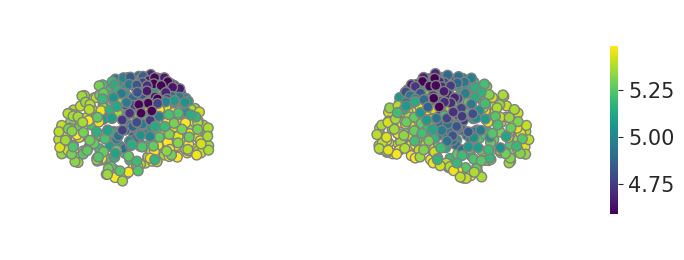

In [6]:
fig, ax = plot_point_brain(mean_timescales, empirical_coords, views=['sag1', 'sag2'], views_orientation='horizontal', cbar=True, cmap='viridis', alpha=1)
fig.savefig(os.path.join(fig_path, 'point_brain_synthetic_timescales.svg'), dpi=300, bbox_inches='tight')

In [7]:
#colorbar minimum and maximum
np.percentile(parc_timescales, [2.5, 97.5])

array([11.27320907, 37.63880978])

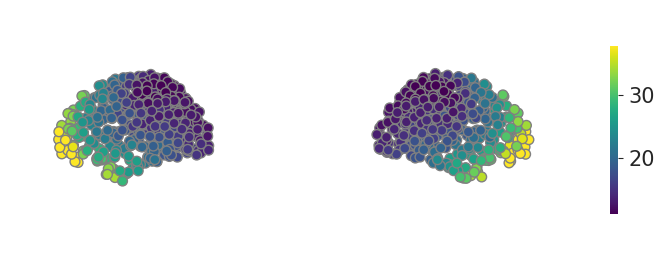

In [8]:
fig, ax = plot_point_brain(parc_timescales, empirical_coords, views=['sag1', 'sag2'], views_orientation='horizontal', cbar=True, cmap='viridis', alpha=1)
fig.savefig(os.path.join(fig_path, 'point_brain_empirical_timescales.svg'), dpi=300, bbox_inches='tight')

In [9]:
from scipy.stats import spearmanr
spearmanr(mean_timescales, parc_timescales)

SpearmanrResult(correlation=0.44397764986031163, pvalue=9.461070840934905e-21)

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

sns.set_style("ticks")
sns.set(context=None, style=None, palette=None, font_scale=5, color_codes=None)
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 15})
plt.rcParams['legend.fontsize'] = 15

PuBu = cm.get_cmap('PuBu')
GnBu = cm.get_cmap('GnBu')
PuRd = cm.get_cmap('PuRd')

ax = sns.regplot(x=mean_timescales, y=parc_timescales, 
                 ci=None, color=PuRd(0.6))
ax.set_box_aspect(1)

ax.set_xlabel('Simulated timescales')
ax.set_ylabel('Empirical timescales')

fig = ax.get_figure()
fig.savefig(os.path.join(fig_path, 'timescale_fit.png'), dpi=300)
fig.savefig(os.path.join(fig_path, 'timescale_fit.svg'), dpi=300)
plt.close(fig)

In [11]:
#null timescales
net_types = ['levelmodular', 'levelhierarchical modular']
timescale_dict = {}
for net_type in net_types:
    timescales = np.zeros((NNETWORKS, nmodules, NNODES))
    for rs_file in os.listdir(rs_path):
        if 'stable' in rs_file and net_type in rs_file:

            filename = rs_file.split('/')[-1]
            seed = int(filename.split('_')[-1][:-4])
            #Get the input module
            module = filename.split('_')[-2]
            module = int(module[6:])
            input_nodes = np.where(module_mappings == module)[0]
            output_nodes = np.where(module_mappings != module)[0]

            rs = np.load(os.path.join(rs_path, rs_file), allow_pickle=True)
            rs = rs.T
            rs = rs[output_nodes] #only keep output timescales

            curr_timescales = Parallel(n_jobs = 25, verbose = 0)(delayed(timescale_analysis)(timeseries) for timeseries in rs)

            timescales[seed, module - 1, output_nodes] = curr_timescales
            timescales[seed, module - 1, input_nodes] = np.nan
    timescale_dict[net_type] = timescales

In [12]:
null_mean_timescales = {}
for net_type in timescale_dict.keys():
    null_mean_timescales[net_type] = np.nanmean(timescale_dict[net_type], axis=1)
with open(os.path.join(experiment_path, 'null_mean_timescales.pickle'), 'wb') as f:
    pickle.dump(null_mean_timescales, f)

In [13]:
null_corrs = {'net_type': [], 'corr': []}
for net_type in net_types:
    for seed in range(NNETWORKS):
        null_corrs['net_type'].append(net_type)
        timescales = null_mean_timescales[net_type][seed]
        null_corrs['corr'].append(spearmanr(parc_timescales, timescales)[0])

In [14]:
ax = sns.kdeplot(data=null_corrs, x='corr', hue='net_type', 
                 palette=[PuBu(0.6), GnBu(0.6)],
                 fill=True, cut=0, alpha=0.8)
empirical_corr = spearmanr(parc_timescales, mean_timescales)[0]
ax.axvline(x=empirical_corr, color=PuRd(0.6), alpha=0.8)
ax.set_box_aspect(1)

ax.set_xlabel('Spearman correlation with empirical timescales')
ax.set_ylabel('Density')

fig = ax.get_figure()
fig.savefig(os.path.join(fig_path, 'null_timescale_fit.png'), dpi=300)
fig.savefig(os.path.join(fig_path, 'null_timescale_fit.svg'), dpi=300)
plt.close(fig)

In [15]:
#deriving p-values from nulls
import pandas as pd
null_corrs_df = pd.DataFrame(null_corrs)

for net_type in net_types:
      curr_null_corrs = null_corrs_df[null_corrs_df['net_type'] == net_type]['corr']

      null_distrib_mean = np.mean(curr_null_corrs)
      demeaned_null_distrib = curr_null_corrs - null_distrib_mean
      demeaned_empirical = empirical_corr - null_distrib_mean
      p_sum=(np.abs(demeaned_null_distrib) >= np.abs(demeaned_empirical)).sum()
      p_val = (p_sum + 1)/(len(demeaned_null_distrib) + 1)

      print('P-value for empirical timescales in contrast to ' +
            f'{net_type[5:]} nulls: {p_val}')

P-value for empirical timescales in contrast to modular nulls: 0.009900990099009901
P-value for empirical timescales in contrast to hierarchical modular nulls: 0.12871287128712872
